In [1]:
from joblib import Parallel, delayed
from query_helper import query_id, query_latest_table, get_ids, get_dates
from pg import con
import pandas as pd

In [2]:
ids = get_ids()

In [11]:
pd.set_option('display.max_columns', None)

In [15]:
idf = query_latest_table(table="gics_kl")

df = pd.read_sql(f"SELECT * FROM marketcap_kl WHERE date>='2022-01-01'", con=con)

fdf = df.merge(idf.drop(['date'], axis=1), on=['id'])
fdf = fdf.drop_duplicates(subset=['date','company_common_name']).dropna(subset=['company_common_name'], axis=0)

bdf = pd.read_excel(r"C:\Users\Bloomberg\projects\quant\data\MK_MKT_GROUP.xlsx", sheet_name='Active', skiprows=5)

bdf['id_sedol'] = bdf['id_sedol1().value']
bdf = bdf.dropna(subset=['id_sedol']).copy()

bdf['id_sedol'] = bdf['id_sedol1().value'].astype(str)

bdf = bdf.rename(columns={'ID': 'bbg_id', 'name().value': 'company_name', 'id_sedol': 'id'})
bdf = bdf[['id','bbg_id', 'company_name']].drop_duplicates(subset=['id']).copy()

fbdf = fdf.merge(bdf, on=['id'])


fbmdf = pd.read_excel('../data/FBM100 as of Jun 26 20231.xlsx')
fbmdf['FBM100'] = True
fbmdf = fbmdf.rename(columns={'Ticker':'bbg_id'})
fbmdf = fbmdf[['bbg_id','FBM100']].copy()

finaldf = fbdf.merge(fbmdf, on=['bbg_id'], how='left')

finaldf['FBM100'] = finaldf['FBM100'].fillna(False)

In [20]:
df1 = finaldf[['date', 'company_market_cap', 'turnover', 'id']].copy()

df2 = finaldf[['id', 'gics_sector_name', 'gics_industry_group_name', 'gics_industry_name', 'gics_sub_industry_name', 'company_common_name', 'FBM100']].copy()
df2 = df2.drop_duplicates(keep='last')

df1.to_csv('../data/daily_data.csv', index=False)
df2.to_csv('../data/meta_data.csv', index=False)

In [16]:
fdf = df1.merge(df2, on=['id'])

,date,company_market_cap,turnover,id,gics_sector_name,gics_industry_group_name,gics_industry_name,gics_sub_industry_name,company_common_name,FBM100
0,2022-01-03,4.350720e+07,0,B1HMM21,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,Watta Holding Bhd,False
1,2022-01-04,4.392960e+07,5690,B1HMM21,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,Watta Holding Bhd,False
2,2022-01-05,4.392960e+07,0,B1HMM21,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,Watta Holding Bhd,False
3,2022-01-06,4.392960e+07,2600,B1HMM21,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,Watta Holding Bhd,False
4,2022-01-07,4.392960e+07,0,B1HMM21,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,Watta Holding Bhd,False
...,...,...,...,...,...,...,...,...,...,...
344744,2022-12-27,1.232762e+08,0,BFX3K33,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Components,Amlex Holdings Bhd,False
344745,2022-12-28,1.233320e+08,0,BFX3K33,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Components,Amlex Holdings Bhd,False
344746,2022-12-29,1.233320e+08,0,BFX3K33,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Components,Amlex Holdings Bhd,False
344747,2022-12-30,1.227740e+08,0,BFX3K33,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Components,Amlex Holdings Bhd,False


In [34]:
fdf['date'].max()

Timestamp('2023-01-12 00:00:00')

In [77]:
fdf = fdf.drop_duplicates(subset=['date','company_common_name'])

In [85]:
fdf[fdf['gics_sector_name'].isna()]['id'].value_counts()

B05F1C8    1199
Name: id, dtype: int64

In [78]:
tdf = fdf.copy()
tdf['month_year'] = tdf['date'].dt.strftime('%b-%Y')
tdf = tdf.groupby(['date', 'month_year','gics_sector_name']).agg({'company_market_cap': 'sum'}).reset_index().pivot_table(index=['date','month_year'], columns=['gics_sector_name'], values=['company_market_cap'])
tdf = tdf.reset_index()
tdf = tdf.sort_values('date').reset_index(drop=True)
tdf.columns = [b if b else a for a,b in tdf.columns]
tdf = tdf.drop_duplicates(subset=['month_year'], keep='last')
tdf = tdf.drop('company_market_cap', axis=1)

In [79]:
tdf

,date,month_year,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
20,2018-01-30,Jan-2018,1.835408e+11,1.341388e+11,2.512264e+11,7.735886e+10,4.184006e+11,9.768805e+10,2.497296e+11,5.187030e+10,1.445022e+11,1.266502e+11,1.645742e+11
38,2018-02-28,Feb-2018,1.762527e+11,1.283169e+11,2.537783e+11,7.850593e+10,4.274462e+11,9.760669e+10,2.398774e+11,5.290849e+10,1.436021e+11,1.235424e+11,1.612343e+11
60,2018-03-30,Mar-2018,1.685155e+11,1.231958e+11,2.614220e+11,7.528740e+10,4.273835e+11,9.820842e+10,2.312564e+11,4.755907e+10,1.360258e+11,1.149814e+11,1.622823e+11
81,2018-04-30,Apr-2018,1.672908e+11,1.248382e+11,2.577656e+11,7.697777e+10,4.306893e+11,9.747949e+10,2.310952e+11,4.510350e+10,1.384958e+11,1.177082e+11,1.606300e+11
99,2018-05-31,May-2018,1.477656e+11,1.254749e+11,2.613234e+11,7.439838e+10,4.075357e+11,9.972301e+10,2.001832e+11,4.135187e+10,1.286125e+11,1.154714e+11,1.454728e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2022-09-30,Sep-2022,1.133840e+11,1.025922e+11,2.274149e+11,5.117230e+10,3.894758e+11,8.089300e+10,1.975741e+11,7.312868e+10,1.470293e+11,8.528787e+10,1.045236e+11
1181,2022-10-31,Oct-2022,1.214556e+11,1.042708e+11,2.372061e+11,5.375036e+10,4.043434e+11,8.578908e+10,2.044076e+11,7.135692e+10,1.545595e+11,8.533571e+10,1.079619e+11
1201,2022-11-30,Nov-2022,1.259125e+11,1.031221e+11,2.343097e+11,5.816687e+10,4.024845e+11,8.238252e+10,2.044302e+11,7.487251e+10,1.571911e+11,8.843599e+10,1.120583e+11
1222,2022-12-30,Dec-2022,1.405238e+11,1.039328e+11,2.440873e+11,5.920106e+10,4.047970e+11,8.766594e+10,2.121766e+11,7.817206e+10,1.603188e+11,8.803045e+10,1.149000e+11


<AxesSubplot:>

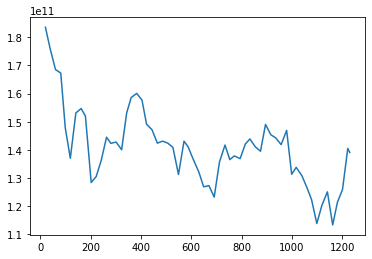

In [80]:
tdf['Communication Services'].plot()

In [81]:
tdf.to_csv('bursa_gics_sector_name.csv', index=False)

In [9]:
df = pd.read_csv('../data/bursa_data.csv')

C:\Users\BLOOMBERG\AppData\Local\Temp\ipykernel_10128\1516218507.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/bursa_data.csv')


In [10]:
df['date'].max()

'2023-01-12'

In [6]:
df['date'] = pd.to_datetime(df['date']).dt.date
udates = sorted(df['date'].unique())
sdate = udates[-5]
edate = udates[-1]
glevel = ['gics_sector_name']

In [7]:
def highlight_rows(x):
    if x.change>0:
        return 'background-color: pink'
    else:
        return 'background-color: blue'

green = [{'selector': 'th', 'props': 'background-color: #98FB98'}]
white = [{'selector': 'th', 'props': 'background-color: ""'}]
red = [{'selector': 'th', 'props': 'background-color: #FFA07A'}]

def highlight_col(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #set by condition
    maskp = df['change'] > 0
    mask0 = df['change'] == 0
    maskn = df['change'] < 0
    df.loc[maskp, :] = 'background-color: #98FB98'
    df.loc[mask0, :] = 'background-color: ""'
    df.loc[maskn, :] = 'background-color: #FFA07A'
    return df 

cols = ['id','gics_sector_name', 'gics_industry_group_name', 'gics_industry_name', 'gics_sub_industry_name', 'company_common_name']

def get_table(df, glevel, sdate, edate):
    fdf = df.sort_values(['date','id']).reset_index(drop=True)
    sdf = fdf[(fdf['date']==sdate)|(fdf['date']==edate)]
    pdf = sdf.pivot_table(index=cols, columns=['date'], values=['company_market_cap']).reset_index().dropna()
    pdf.columns = [b if b else a for a,b in pdf.columns]
    adf = pdf.groupby(glevel)[[sdate, edate]].sum()
    adf['change'] = adf[edate] - adf[sdate]
    adf['change_pct'] = adf['change']/adf[sdate]*100
    a={}
    for k,i in zip(adf.index, adf['change']):
        if i>0:
            a[k]=green
        elif i<0:
            a[k]=red
        else:
            a[k]=white
    
    return adf.style.format("{:,.0f}", subset=[sdate,edate,'change']).format("{:,.2f}%", subset=['change_pct'])\
    .bar(subset=(adf['change_pct']<0, 'change_pct'), color='#FF6347', align="zero")\
    .bar(subset=(adf['change_pct']>0, 'change_pct'), color="#54C571", align="zero")\
    .apply(highlight_col, subset=[i for i in adf.columns if i!='change_pct'], axis=None)\
    .set_table_styles(a, axis=1)

In [ ]:
get_table(df, glevel, sdate, edate)

In [419]:
fdf = df.sort_values(['date','id']).reset_index(drop=True)
sdf = fdf[(fdf['date']==sdate)|(fdf['date']==edate)]
pdf = sdf.pivot_table(index=cols, columns=['date'], values=['company_market_cap']).reset_index()
pdf.columns = [b if b else a for a,b in pdf.columns]
adf = pdf.groupby(glevel)[[sdate, edate]].sum()#.reset_index()
adf['change'] = adf[edate] - adf[sdate]
adf['change_pct'] = adf['change']/adf[sdate]*100

In [460]:
{ k:green if i>0 else k:red if i<0 else k:white for k,i in zip(adf.index,adf['change'])}

SyntaxError: invalid syntax (1403340961.py, line 1)

In [246]:
import matplotlib.pyplot as plt
%matplotlib inline

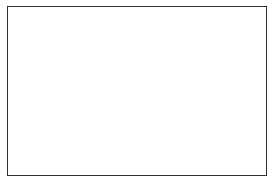

In [249]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(4,2.6),
                         gridspec_kw={"width_ratios":[1,0.5,2]})
fig.subplots_adjust(0.05,0.05,0.95,0.95, wspace=0.05, hspace=0)
for ax in axes.flatten():
    ax.tick_params(labelbottom=0, labelleft=0, bottom=0, top=0, left=0, right=0)
    ax.ticklabel_format(useOffset=False, style="plain")
    for _,s in ax.spines.items():
        s.set_visible(False)
border = fig.add_subplot(111)
border.tick_params(labelbottom=0, labelleft=0, bottom=0, top=0, left=0, right=0)
border.set_facecolor("None")

In [4]:
import eikon as ek
import pandas as pd
from datetime import datetime

with open(r"C:\Users\BLOOMBERG\projects\config\app_key_daniel.txt", 'r') as file:
    APP_KEY = file.read()
ek.set_app_key(APP_KEY)

In [57]:
df, err = ek.get_data(instruments = ['0#.KLFT100'], 
                      fields = ['CF_LAST', 'weight'],
                      parameters = {
                          'SDate': '2023-01-19',
                          'EDate': '0',
                      }
                     )

In [58]:
df

,Instrument,CF_LAST,WEIGHT
0,ALLI.KL,3.62,<NA>
1,AEOM.KL,1.35,<NA>
2,AFIN.KL,2.1,<NA>
3,AMMB.KL,4.06,<NA>
4,ASTR.KL,0.61,<NA>
...,...,...,...
95,VTRX.KL,7.78,<NA>
96,VSID.KL,0.895,<NA>
97,WPHB.KL,3.77,<NA>
98,YINS.KL,2.64,<NA>
